In [1]:
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
# library for plotting arrays
import matplotlib.pyplot
%matplotlib inline
# scipy.misc for loading png images
import scipy.misc
# scipy.ndimage for rotating images
import scipy.ndimage

In [2]:
class neuralNetwork:
    WIH_FILENAME = "wih.csv"
    WHO_FILENAME = "who.csv"
    
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        self.lr = learningrate
        
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # activation function is the sigmoid function (declared as a lambda so it's only called from one place) 
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
            
        
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate singals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
    
    
    def query(self, input_list):
        # convert inputs list to 2d array
        inputs = numpy.array(input_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_outputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from the output layer
        final_outputs = self.activation_function(final_outputs)
        
        return final_outputs
    
    # backquery the neural network
    # we'll use the same terminology to each item,
    # eg target are the values at the right of the network, albeit used as input
    # hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_output = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_output)
        
        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to 0.99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale the back to 0.01 to 0.99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs
    
    
    def save(self):
        numpy.savetxt(neuralNetwork.WHO_FILENAME, self.who, delimiter=",")
        numpy.savetxt(neuralNetwork.WIH_FILENAME, self.wih, delimiter=",")
        print("Neural network saved")
    
    def load(self):
        self.who = numpy.genfromtxt(neuralNetwork.WHO_FILENAME, delimiter=",")
        self.wih = numpy.genfromtxt(neuralNetwork.WIH_FILENAME, delimiter=",")
        print("Neural network loaded")

In [3]:
TRAIN_NETWORK = False
TRAIN_NETWORK_WITH_ROTATED_VARIATIONS = False
SAVE_NETWORK = False
TEST_NETWORK = False
TEST_SELF_CREATED_IMAGE = True
BACKQUERY_NETWORK = True

input_nodes = 784
hidden_nodes = 200
output_nodes = 10
learning_rate = 0.01 # 0.2 SWEET SPOT: 0.1, 0.01 with rotated variations
training_data_filepath = "mnist_dataset/mnist_train_100.csv"
#training_data_filepath = "mnist_dataset/mnist_train.csv"
test_data_filepath = "mnist_dataset/mnist_test_10.csv"
#test_data_filepath = "mnist_dataset/mnist_test.csv"

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

if TRAIN_NETWORK:
    # load the mnist training data CSV file into a list
    training_data_file = open(training_data_filepath, "r")
    training_data_list = training_data_file.readlines()
    training_data_file.close()

    # train the neural network
    # epochs is the number of times the training data set is used for training
    epochs = 10 # 1 SWEET SPOT: 5, 10 with rotated variations

    for e in range(epochs):
        # go through all records in the training data set
        for record in training_data_list:
            # split the record by commas
            all_values = record.split(",")
            # scale and shift the inputs
            inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
            # create the target output values (all 0.01, except the desired label which is 0.99)
            targets = numpy.zeros(output_nodes) + 0.01
            # all_values[0] is the target label for this record
            targets[int(all_values[0])] = 0.99
            n.train(inputs, targets)
            
            if TRAIN_NETWORK_WITH_ROTATED_VARIATIONS:
                # create rotated variations
                # rotated anticlockwise by 10 degrees
                inputs_plus10_image = scipy.ndimage.rotate(inputs.reshape((28,28)), 10.0, cval=0.01, order=1, reshape=False)
                n.train(inputs_plus10_image.reshape(784), targets)
                # rotated clockwise by 10 degrees
                inputs_minus10_image = scipy.ndimage.rotate(inputs.reshape((28,28)), -10.0, cval=0.01, order=1, reshape=False)
                n.train(inputs_minus10_image.reshape(784), targets)

In [4]:
if SAVE_NETWORK:
    n.save()

Neural network loaded
[[ 0.20497868]
 [ 0.00114656]
 [ 0.02325594]
 [ 0.07921041]
 [ 0.00160476]
 [ 0.00491801]
 [ 0.03525565]
 [ 0.1766442 ]
 [ 0.00249628]
 [ 0.11104171]]


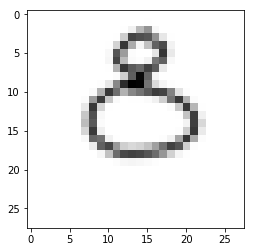

In [5]:
if TEST_SELF_CREATED_IMAGE:
    # *** TEST A SELF CREATED IMAGE (GIMP) ***
    # Need to run all above cells once to create neural network
    n.load()

    image = scipy.misc.imread("mnist_dataset/MyTestImage.png", flatten=True)
    image = scipy.misc.imresize(image, (28,28))

    image = 255.0 - image.reshape(784)
    image_array = numpy.asfarray(image).reshape((28,28))
    matplotlib.pyplot.imshow(image_array, cmap="Greys", interpolation="None")

    print(n.query((image / 255 * 0.99) + 0.01))

4


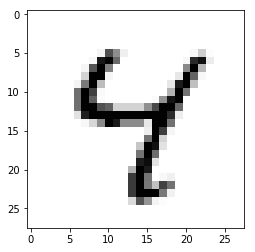

In [6]:
# load the mnist test data CSV file into a list
test_data_file = open(test_data_filepath, "r")
test_data_list = test_data_file.readlines()
test_data_file.close()

# get the first record
all_values = test_data_list[6].split(",")
# print the label
print(all_values[0])

image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap="Greys", interpolation="None")

In [7]:
n.query((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)

array([[  1.28525660e-03],
       [  1.61976036e-02],
       [  6.13311676e-03],
       [  5.48525507e-04],
       [  9.94567764e-01],
       [  5.99301719e-03],
       [  3.22350846e-03],
       [  1.29165176e-02],
       [  3.56647296e-02],
       [  6.04087080e-03]])

In [8]:
# test the neural network
if TEST_NETWORK:
    # scorecard for how well the network performs, initially empty
    scorecard = []

    # go through all the records in the test data set
    for record in test_data_list:
        # split the record by commas
        all_values = record.split(",")
        # correct answer is first value
        correct_label = int(all_values[0])
        #print(correct_label, "correct label")
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # query the network
        outputs = n.query(inputs)
        # the index of the highest value corresponds to the label
        label = numpy.argmax(outputs)
        #print(label, "network's answer")
        # append correct or incorrect to list
        if (label == correct_label):
            # network's answer matches correct answer, add 1 to scorecard
            scorecard.append(1)
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            scorecard.append(0)
    
    # calculate the performance score, the fraction of correct answers
    scorecard_array = numpy.asarray(scorecard)
    print("performance = ", scorecard_array.sum() / scorecard_array.size)

Neural network loaded
[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.99  0.01]


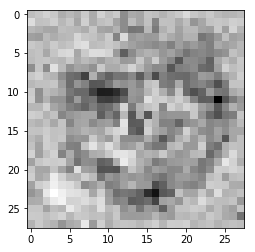

In [9]:
# run the network backwards: given a label, see what image it produces
if BACKQUERY_NETWORK:
    n.load()
    
    # label to test
    label = 8
    # create the output signals for this label
    targets = numpy.zeros(output_nodes) + 0.01
    # all_values[0] is the target label for this record
    targets[label] = 0.99
    print(targets)
    
    # get image data
    image_data = n.backquery(targets)
    
    # plot image data
    matplotlib.pyplot.imshow(image_data.reshape((28,28)), cmap="Greys", interpolation="None")